This notebook continues where we left off in notebook 02. We will attach an aesthetic predictor to the model and make our first (baby) steps towards optimization.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import json
from math import prod
from huggingface_hub import hf_hub_download
import tqdm
transform_t_to_pil = T.ToPILImage()

/Users/mowoe/Documents/bachelorthesis/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Utility functions to read dataset

def get_all_bounding_boxes(item):
    all_boxes = []
    if "bounds" in item.keys():
        all_boxes.append(item["bounds"])
    if "children" in item.keys():
        for child in item["children"]:
            for box in get_all_bounding_boxes(child):
                all_boxes.append(box)
    return all_boxes
"""
returns a list of the segments and a list of coordinates
"""
def segment(image: np.ndarray, rico_json: dict)->[list,list]:
    boxes = get_all_bounding_boxes(rico_json["activity"]["root"])
    segments = []
    coordinates = []
    for box in boxes:
        anchor_point = (box[0],box[1])
        width = box[2]-box[0]
        height = box[3]-box[1]
        cropped_image = im.crop((box[0],box[1],box[2],box[3]))
        # Only include segments that are less than 90% the size of the original image
        if (width*height) < 0.9*(im.size[0]*im.size[1]):
            segments.append(cropped_image)
            coordinates.append((box[0],box[1]))
    return list(zip(segments,coordinates))

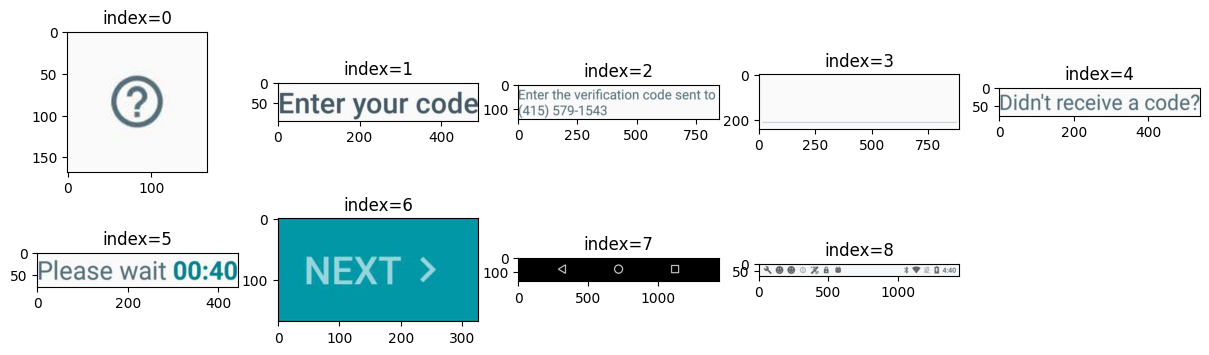

In [3]:
im = Image.open('combined/5373.jpg')
im = im.resize((1440, 2560), Image.Resampling.LANCZOS)
with open("combined/5373.json", "r") as f:
    image_json = json.load(f)
reduced_segments = [s for s in segment(im,image_json) if (prod(s[0].size) < 0.80*prod(im.size)) and (prod(s[0].size)>1)]
even_more_reduced_segments = [reduced_segments[i] for i in [2,4,5,6,7,8,10,11,12]]
fig = plt.figure(figsize=(15, 4)) 
for n in range(len(even_more_reduced_segments)):
    fig.add_subplot(2, 5, n+1) 
    plt.imshow(even_more_reduced_segments[n][0])
    plt.title(f"index={n}")

In [4]:
class AestheticPredictor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=0)
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=0)
        self.global_avg_pooling = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = torch.nn.Linear(32, 4096)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(4096, 1)
        # Download the model from HF Hub
        local_filename = hf_hub_download(repo_id="mowoe/modeling_how_different_user_groups_model", filename="model.pt")
        self.load_state_dict(torch.load(local_filename, map_location="cpu"))
        self.eval()

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.global_avg_pooling(x)
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [5]:
def calculate_initial_theta(segment, canvas_size, original_position):
    # Theta consists of 6 values, 4 of which we have to calculate.
    x_ratio = canvas_size[0] / segment.size[0]
    y_ratio = canvas_size[1] / segment.size[1]
    # grid_location_x and grid_location_y are basically percentages of height and width and not actual coordinates
    # Because we already warp the segment onto a bigger canvas, this transformation is a bit complicated
    # grid_location_x has to be in the interval [-(x_ratio-1),(x_ratio-1)], i.e. 0 means -(x_ratio - 1) and 1440 means (x_ratio - 1)
    # We can map U ~ [0, 1] to U ~ [a, b] with u -> (a - b)*u + b
    # We first map U ~ [0, max_width] to U ~ [0,1] by dividing by max_width
    original_x_position = original_position[0] / canvas_size[0]
    mapped_x_position = (-(x_ratio - 1) - (x_ratio - 1))*original_x_position + (x_ratio-1)

    original_y_position = original_position[1] / canvas_size[1]
    mapped_y_position = (-(y_ratio - 1) - (y_ratio - 1))*original_y_position + (y_ratio-1)

    return np.array([
        [x_ratio, 0.0    , mapped_x_position],
        [0.0    , y_ratio, mapped_y_position]
    ])

In [6]:
transform = transforms.Compose([transforms.ToTensor()])


class MultiSegmentUIOptimizer(torch.nn.Module):
    def __init__(self,segments_and_positions: list, original_image_size: tuple, debug=False,debug_stacking_strategy="sum"):
        super().__init__()
        self.original_image_size = original_image_size
        self.segments_and_positions = segments_and_positions
        self.canvas_size = (1,3,original_image_size[1],original_image_size[0])
        self.debug_stacking_strategy = debug_stacking_strategy
        self.debug = debug
        print(f"Canvas size is {self.canvas_size}")

        initial_vector = []
        for segment,position in segments_and_positions:
            initial_theta = calculate_initial_theta(segment,original_image_size,position)
            initial_vector.append([initial_theta[0][2],initial_theta[1][2]])

        self.coordinates = torch.nn.Parameter(torch.tensor(initial_vector))
        print(self.coordinates)
        #init_vector = -5 * torch.rand(len(segments),2) + 2.5 # https://stackoverflow.com/questions/65617507/how-to-create-a-tensor-of-given-shape-and-interval 
        #self.coordinates = torch.nn.Parameter(init_vector) # 2 floats per segment, for grid_location_x and grid_location_y
        

    def forward(self):
        segments_on_canvas = []
        for n in range(len(self.segments_and_positions)):
            # We need to calculate the proper ratios, to artificially warp the segment on to a bigger canvas without distorting it (see notebook 01)
            x_ratio = self.original_image_size[0] / self.segments_and_positions[n][0].size[0]
            y_ratio = self.original_image_size[1] / self.segments_and_positions[n][0].size[1]
            # Affine matrix
            ########### WILL BREAK GRADIENT! ###########
            #theta = [
            #    [x_ratio, 0.0    , self.coordinates[n][0]],
            #    [0.0    , y_ratio, self.coordinates[n][1]]
            #]

            theta = [
                [x_ratio, 0.0    , 0.0],
                [0.0    , y_ratio, 0.0]
            ]
            theta_tensor = torch.as_tensor(theta)[None]
            #print(theta_tensor)
            theta_tensor[0][0][2]+=self.coordinates[n][0]
            theta_tensor[0][1][2]+=self.coordinates[n][1]
            #print(theta_tensor)
            
            ############################################
            
            # Generate flow field
            grid = F.affine_grid(theta_tensor, self.canvas_size).type(torch.FloatTensor)
            x = F.grid_sample(transform(self.segments_and_positions[n][0]).unsqueeze(0), grid)
            segments_on_canvas.append(x)
            if self.debug:
                if self.debug_stacking_strategy=="mean":
                    canvas_sum = torch.stack(segments_on_canvas).mean(dim=0)[0].permute(1, 2, 0).detach()
                else:
                    canvas_sum = torch.stack(segments_on_canvas).sum(dim=0)[0].permute(1, 2, 0).detach()
                plt.imshow(canvas_sum)
                plt.axis('off')
                plt.show()
        return segments_on_canvas

In [7]:
device = "cpu"
reduced_msUIo = MultiSegmentUIOptimizer(even_more_reduced_segments, im.size)
optimizer = torch.optim.SGD([reduced_msUIo.coordinates], lr=0.01, momentum=0.9)
aesthetic_predictor = AestheticPredictor()#.to(device, torch.float16)

Canvas size is (1, 3, 2560, 1440)
Parameter containing:
tensor([[ -5.8048,  13.3037],
        [  1.6321,  21.3044],
        [  0.5895,  12.0661],
        [  0.5249,   5.3056],
        [  1.4158,  11.2097],
        [  1.8943,   9.2690],
        [ -1.8578, -10.5006],
        [  0.0000, -12.3693],
        [  0.0000,  29.4762]], dtype=torch.float64, requires_grad=True)


In [8]:
scores = []
for x in tqdm.tqdm(range(15)):
    optimizer.zero_grad()
    canvasses = reduced_msUIo()
    generated_image = torch.stack(canvasses).sum(dim=0)
    print(torch.sum(generated_image))
    score = aesthetic_predictor(generated_image)
    print(f"score: {score.item()}")
    loss = -score
    loss.backward()
    optimizer.step()
    #print(reduced_msUIo.coordinates)
    scores.append(score.item())

  0%|                                                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]/Users/mowoe/Documents/bachelorthesis/venv/lib/python3.11/site-packages/torch/nn/functional.py:4377: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/mowoe/Documents/bachelorthesis/venv/lib/python3.11/site-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor(1762297.8750, grad_fn=<SumBackward0>)
score: 5.496748447418213


  7%|█████████████▎                                                                                                                                                                                          | 1/15 [00:26<06:14, 26.76s/it]

tensor(1761365.5000, grad_fn=<SumBackward0>)
score: 5.495874404907227


 13%|██████████████████████████▋                                                                                                                                                                             | 2/15 [00:55<06:02, 27.89s/it]

tensor(1759763., grad_fn=<SumBackward0>)
score: 5.497942924499512


 20%|████████████████████████████████████████                                                                                                                                                                | 3/15 [01:22<05:28, 27.41s/it]

tensor(1758279.8750, grad_fn=<SumBackward0>)
score: 5.497356414794922


 27%|█████████████████████████████████████████████████████▎                                                                                                                                                  | 4/15 [01:48<04:56, 26.93s/it]

tensor(1756809., grad_fn=<SumBackward0>)
score: 5.49587345123291


 33%|██████████████████████████████████████████████████████████████████▋                                                                                                                                     | 5/15 [02:14<04:24, 26.48s/it]

tensor(1755899.8750, grad_fn=<SumBackward0>)
score: 5.49615478515625


 40%|████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 6/15 [02:39<03:55, 26.12s/it]

tensor(1755560.6250, grad_fn=<SumBackward0>)
score: 5.4964213371276855


 47%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 7/15 [03:05<03:29, 26.20s/it]

tensor(1755332.7500, grad_fn=<SumBackward0>)
score: 5.496661186218262


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 8/15 [03:31<03:01, 25.96s/it]

tensor(1755040.6250, grad_fn=<SumBackward0>)
score: 5.4963483810424805


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 9/15 [03:56<02:35, 25.83s/it]

tensor(1755188.1250, grad_fn=<SumBackward0>)
score: 5.49668550491333


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 10/15 [04:22<02:08, 25.73s/it]

tensor(1754386.6250, grad_fn=<SumBackward0>)
score: 5.496716499328613


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 11/15 [04:53<01:49, 27.30s/it]

tensor(1753321.7500, grad_fn=<SumBackward0>)
score: 5.496487617492676


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 12/15 [05:21<01:22, 27.55s/it]

tensor(1752770., grad_fn=<SumBackward0>)
score: 5.496110916137695


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 13/15 [05:48<00:54, 27.49s/it]

tensor(1752672.3750, grad_fn=<SumBackward0>)
score: 5.496856212615967


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 14/15 [06:14<00:26, 26.86s/it]

tensor(1752697., grad_fn=<SumBackward0>)
score: 5.498152732849121


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [06:40<00:00, 26.69s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

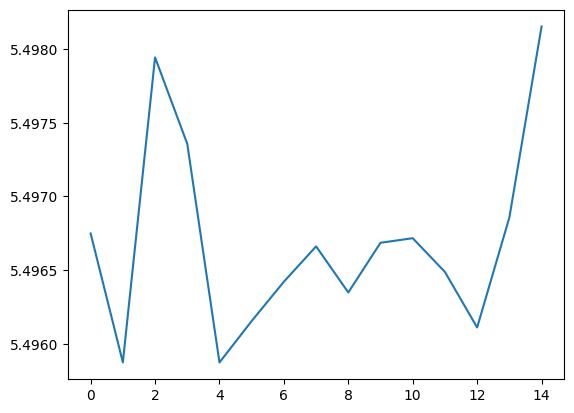

In [9]:
plt.plot(scores)
plt.show

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


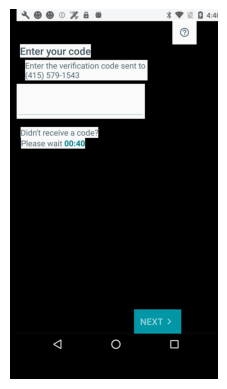

In [56]:
canvasses = reduced_msUIo()
canvas_sum = torch.stack(canvasses).sum(dim=0)[0].permute(1, 2, 0).detach()
plt.imshow(canvas_sum)
plt.axis('off')
plt.show()